# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

from sklearn import metrics
from scipy.stats import ks_2samp

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [4]:
def analise_bivariada_categ (df: pd.DataFrame, nome_resp:str, nome_expl:str) -> (pd.DataFrame):
    df_bivariada = (pd.crosstab(df[nome_expl], df[nome_resp], margins= True)
       .assign(Probabilidade = lambda x: x[1]/x['All'])
       .assign(Chance = lambda x: x[1]/x[0])
       .assign(Razão_Chance = lambda x: x['Chance']/x.loc['All','Chance'])
       .assign(Log_Chance = lambda x: np.log(x['Chance']))
       .assign(Log_Razão_Chance = lambda x: np.log(x['Razão_Chance']))              
      )
           
    return df_bivariada

In [5]:
analise_bivariada_categ(df=df, nome_resp = 'flag_doente', nome_expl ='sex' )

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
sex,,,,,,,,
0.0,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
1.0,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [6]:
analise_bivariada_categ(df=df, nome_resp = 'flag_doente', nome_expl ='cp' )

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
cp,,,,,,,,
1.0,16,7,23,0.304348,0.437500,0.516187,-0.826679,-0.661286
2.0,41,9,50,0.180000,0.219512,0.258993,-1.516347,-1.350955
3.0,68,18,86,0.209302,0.264706,0.312315,-1.329136,-1.163743
4.0,39,105,144,0.729167,2.692308,3.176536,0.990399,1.155791
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [7]:
analise_bivariada_categ(df=df, nome_resp = 'flag_doente', nome_expl ='restecg' )

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
restecg,,,,,,,,
0.0,95,56,151,0.370861,0.589474,0.695494,-0.528525,-0.363133
1.0,1,3,4,0.750000,3.000000,3.539568,1.098612,1.264005
2.0,68,80,148,0.540541,1.176471,1.388066,0.162519,0.327911
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [8]:
analise_bivariada_categ(df=df, nome_resp = 'flag_doente', nome_expl ='slope' )

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
slope,,,,,,,,
1.0,106,36,142,0.253521,0.339623,0.400706,-1.079920,-0.914528
2.0,49,91,140,0.650000,1.857143,2.191161,0.619039,0.784432
3.0,9,12,21,0.571429,1.333333,1.573141,0.287682,0.453075
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [9]:
def analise_bivariada_quant (df: pd.DataFrame, nome_resp:str, nome_expl:str, faixas:int = 5  ) -> (pd.DataFrame):
    
    expl_range = pd.qcut(df[nome_expl],q=faixas,precision = 0)
    
    df_bivariada = (pd.crosstab(expl_range, df[nome_resp], margins= True)
       .assign(Probabilidade = lambda x: x[1]/x['All'])
       .assign(Chance = lambda x: x[1]/x[0])
       .assign(Razão_Chance = lambda x: x['Chance']/x.loc['All','Chance'])
       .assign(Log_Chance = lambda x: np.log(x['Chance']))
       .assign(Log_Razão_Chance = lambda x: np.log(x['Razão_Chance']))              
      )
           
    return df_bivariada

In [10]:
analise_bivariada_quant(df = df, nome_resp = 'flag_doente', nome_expl = 'age')

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
age,,,,,,,,
"(28.0, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [11]:
analise_bivariada_quant(df = df, nome_resp = 'flag_doente', nome_expl = 'trestbps')

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
trestbps,,,,,,,,
"(93.0, 120.0]",60,37,97,0.381443,0.616667,0.727578,-0.483427,-0.318034
"(120.0, 126.0]",10,15,25,0.600000,1.500000,1.769784,0.405465,0.570858
"(126.0, 134.0]",35,27,62,0.435484,0.771429,0.910175,-0.259511,-0.094119
"(134.0, 145.0]",34,24,58,0.413793,0.705882,0.832840,-0.348307,-0.182914
"(145.0, 200.0]",25,36,61,0.590164,1.440000,1.698993,0.364643,0.530036
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [12]:
analise_bivariada_quant(df = df, nome_resp = 'flag_doente', nome_expl = 'chol')

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
chol,,,,,,,,
"(125.0, 204.0]",37,25,62,0.403226,0.675676,0.797200,-0.392042,-0.226650
"(204.0, 230.0]",36,24,60,0.400000,0.666667,0.786571,-0.405465,-0.240073
"(230.0, 254.0]",36,26,62,0.419355,0.722222,0.852118,-0.325422,-0.160030
"(254.0, 286.0]",27,32,59,0.542373,1.185185,1.398348,0.169899,0.335292
"(286.0, 564.0]",28,32,60,0.533333,1.142857,1.348407,0.133531,0.298924
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [14]:
reglog = smf.logit(" flag_doente ~ C(sex) + C(cp) + trestbps + age " 
                   , data = df).fit()

reglog.summary()

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Tue, 13 Feb 2024   Pseudo R-squ.:                  0.3097
Time:                        07:13:25   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.3407      1.621     -5.145      0.000     -11.518      -5.163
C(sex)[T.1.0]     1.8094      0.353      5.130      0.000       1.118       2.501
C(cp)[T.2.0]     -0.0617      0.636     -0.097      0.923      -1.309       1.186
C(cp)[T.3.0]      0.0715      0.573      0.125      0.901      -1.051       1.194
C(cp)[T.4.0]      2.4789      0.553      4.485      0.000       1.396       3.562
trestbps          0.0193      0.009      2.261      0.024       0.003       0.036
age               0.0567      0.018      3.120      0.002       0.021       0.092
=================================================================================
"""

As variáveis C(cp)[T.2.0] e C(cp)[T.3.0] são estatisticamente insignificantes para o modelo (pvalue maior que 5%), ou seja sentir qualquer um dos 3 tipos de dor tem a mesma relevância para definirmos se o paciente tem doença cardiáca.

Já ser assintomático, C(cp)[T.4.0], mostrou ser bem relevante para o modelo. Além de ser estatisticamente significante ((pvalue =0)), o paciente assintomatico possui pelo menos 11 x a chance de ter a doença que um paciente com algum dos 3 tipos de dores.

O sexo também tem extrema importância para o modelo já que há 6x mais homens doentes que mulheres.

Já trestbps é estatisticamente significante mas influencia bem menos o modelo.

A idade se mostrou estatisticamente significante para o modelo (pvalue menor que 5%).

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [16]:
# adiciona ao df a coluna predito com a probabilidade predita de ter a doença para cada pessoa
df['predito'] = reglog.predict(df) 
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.458229
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.944123
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.886566
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.134929
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.027278


In [19]:
cat_pred = pd.qcut(df['predito'], 5, duplicates='drop') # criar 5 faixas de probabilidade mais ou menos com o mesmo número de pessoas
cat_pred.value_counts().sort_index() # organiza as faixas em ordem crescente

(0.0131, 0.143]    62
(0.143, 0.287]     59
(0.287, 0.586]     62
(0.586, 0.822]     59
(0.822, 0.944]     61
Name: predito, dtype: int64

In [20]:
group_reg = df.groupby(cat_pred) #Cria um grupo pelas faixas de categoria
qualidade = (group_reg[['flag_doente']].count() #contagem de pacientes por faixa de probabilidade de estar doente
            .assign(Predito = lambda x: group_reg['predito'].mean())# calcula a média do valor predito, pois fica mais fácil de usar que a faixa
            .assign(Pct_Doentes =  lambda x:group_reg['flag_doente'].mean()) # obtemos a media do observado para comparar com a media do predito

            ) 
qualidade

,flag_doente,Predito,Pct_Doentes
predito,,,
"(0.0131, 0.143]",62,0.072008,0.080645
"(0.143, 0.287]",59,0.209626,0.152542
"(0.287, 0.586]",62,0.435175,0.483871
"(0.586, 0.822]",59,0.708861,0.762712
"(0.822, 0.944]",61,0.874819,0.819672


Text(0.5, 0, 'Grupo')

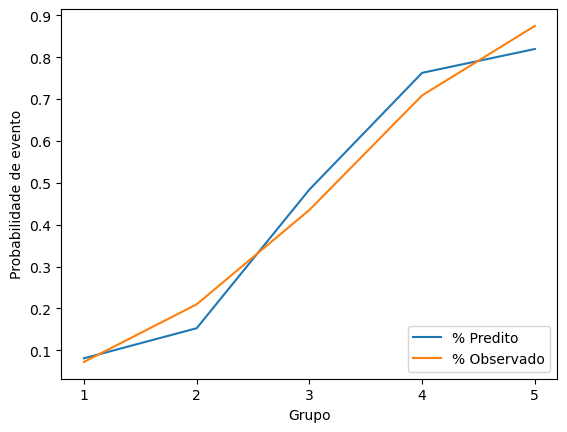

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualidade['Pct_Doentes'].plot(label='% Predito')
ax = qualidade['Predito'].plot(label='% Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [28]:
acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

##Gini
gini = 2*auc_ -1

#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('GINI: {2:.2f}% \n KS: {0:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 79.54%
GINI: 70.39% 
 KS: 59.30%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [29]:
#'flag_doente ~ sex + cp + trestbps + age + chol + fbs + restecg + thalach + exang + oldpeak + slope + ca + thal'
#'flag_doente ~ sex + cp + trestbps + age + chol + fbs + restecg + thalach + exang + oldpeak + slope'
#'flag_doente ~ sex + cp + trestbps + age + chol + fbs + restecg + thalach + exang + oldpeak'
#'flag_doente ~ sex + cp + trestbps + age + chol + fbs + restecg + thalach + exang'
#'flag_doente ~ sex + cp + trestbps + age + chol + fbs + restecg + thalach'
#'flag_doente ~ sex + cp + trestbps + age + chol + fbs + restecg'
#'flag_doente ~ sex + cp + trestbps + age + chol + fbs'
#'flag_doente ~ sex + cp + trestbps + age + chol'
#'flag_doente ~ sex + cp + trestbps + age'



reglog = smf.logit('flag_doente ~ sex + cp + trestbps + age + chol + fbs + restecg + thalach + exang + oldpeak + slope + ca + thal', data=df).fit()

reglog.summary()

Optimization terminated successfully.
         Current function value: 0.326870
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      284
Method:                           MLE   Df Model:                           18
Date:                Tue, 13 Feb 2024   Pseudo R-squ.:                  0.5261
Time:                        07:47:17   Log-Likelihood:                -99.042
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.014e-36
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -6.7182      2.934     -2.290      0.022     -12.468      -0.968
ca[T.1.0]       1.9115      0.481      3.975      0.000       0.969       2.854
ca[T.2.0]       3.4183      0.738      4.632      0.000       1.972       4.865
ca[T.3.0]       2.0080      0.848      2.368      0.018       0.346       3.670
ca[T.?]        -0.4958      1.651     -0.300      0.764      -3.731       2.740
thal[T.6.0]     0.0163      0.798      0.020      0.984      -1.548       1.581
thal[T.7.0]     1.4101      0.415      3.400      0.001       0.597       2.223
thal[T.?]       1.8895      1.645      1.149      0.251      -1.334       5.113
sex             1.5811      0.513      3.083      0.002       0.576       2.586
cp              0.6892      0.202      3.416      0.001       0.294       1.085
trestbps        0.0279      0.011      2.504      0.012       0.006       0.050
age            -0.0242      0.024     -0.988      0.323      -0.072       0.024
chol            0.0053      0.004      1.389      0.165      -0.002       0.013
fbs            -0.7441      0.531     -1.400      0.161      -1.786       0.297
restecg         0.2527      0.189      1.337      0.181      -0.118       0.623
thalach        -0.0249      0.011     -2.279      0.023      -0.046      -0.003
exang           0.9508      0.420      2.266      0.023       0.128       1.773
oldpeak         0.2315      0.221      1.049      0.294      -0.201       0.664
slope           0.7404      0.376      1.970      0.049       0.004       1.477
===============================================================================
"""

In [30]:
# - Calcule a probabilidade de evento predita segundo o seu modelo:

df['predito'] = reglog.predict(df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.131065
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.989922
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.996731
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.346831
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.012952


In [32]:
#Criando dataframe para avaliar a calibragem
df['predito'] = reglog.predict(df)  #adiciona  a probabilidade predita do novo modelo ao df
cat_pred = pd.qcut(df['predito'], 5) # criar 5 faixas de probabilidade mais ou menos com o mesmo número de pessoas
group_reg = df.groupby(cat_pred) #Cria um grupo pelas faixas de categoria
qualidade2 = (group_reg[['flag_doente']].count() #contagem de pacientes por faixa de probabilidade de estar doente
            .assign(Predito = lambda x: group_reg['predito'].mean())# calcula a média do valor predito, pois fica mais fácil de usar que a faixa
            .assign(Pct_Doentes =  lambda x:group_reg['flag_doente'].mean()) # obtemos a media do observado para comparar com a media do predito

            ) 
qualidade2

,flag_doente,Predito,Pct_Doentes
predito,,,
"(0.00152, 0.0509]",61,0.024937,0.032787
"(0.0509, 0.205]",60,0.116331,0.133333
"(0.205, 0.599]",61,0.364347,0.278689
"(0.599, 0.946]",60,0.808634,0.866667
"(0.946, 0.999]",61,0.979602,0.983607


Text(0.5, 1.05, 'Segundo Modelo')

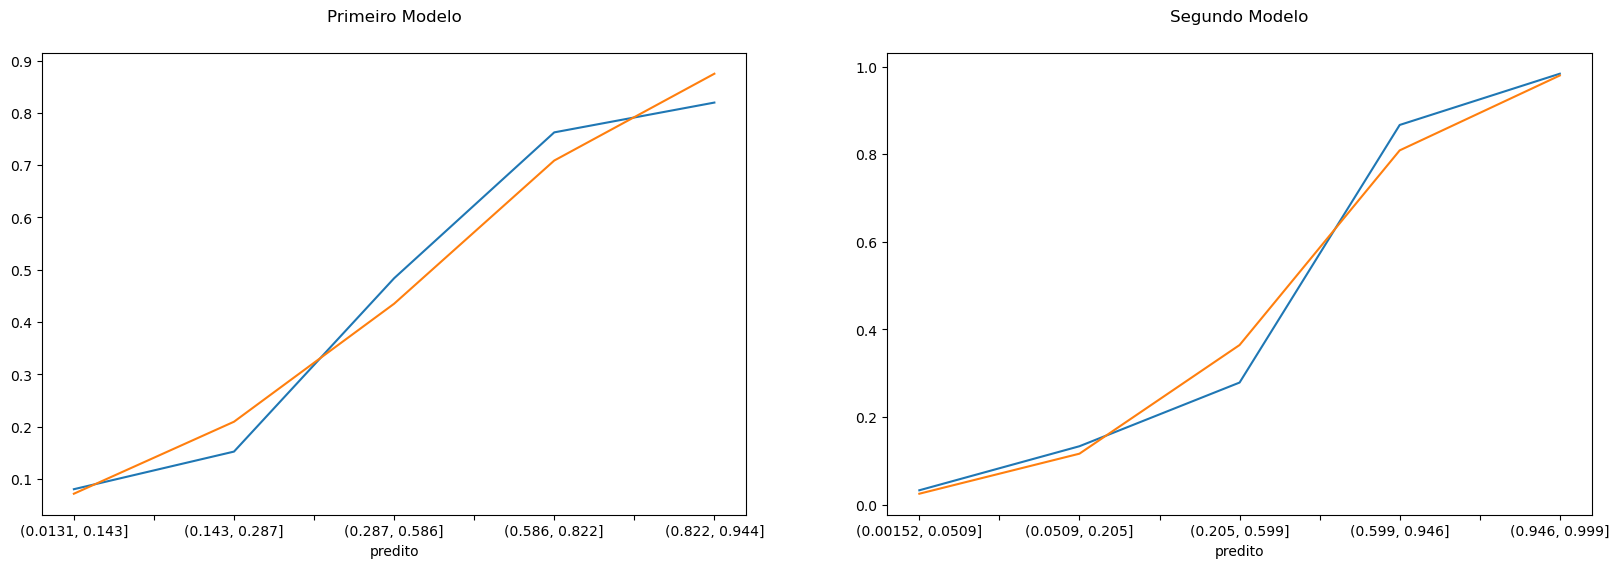

In [34]:
#Graficos comparativos da Qualidade dos dois modelos
#configurando um sistema de eixos
plt.rc('figure', figsize=(20, 6))
fig, axes = plt.subplots(1, 2)
#gráfico  qualidade primeiro modelo
ax1 = axes[0]
qualidade['Pct_Doentes'].plot(label='% Predito', ax = ax1)
qualidade['Predito'].plot(label='% Observado', ax = ax1)
#gráfico qualidade segundo modelo
ax2 = axes[1]
qualidade2['Pct_Doentes'].plot(label='% Predito', ax = ax2)
qualidade2['Predito'].plot(label='% Observado', ax = ax2)
#Configurando os títulos dos graficos
ax1.set_title ('Primeiro Modelo', y= 1.05)
ax2.set_title ('Segundo Modelo', y= 1.05)

In [35]:
acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

##Gini
gini = 2*auc_ -1

#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('GINI: {2:.2f}% \n KS: {0:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 85.81%
GINI: 70.39% 
 KS: 75.09%


Podemos ver que a adição das novas variáveis no modelo 2 resultou em um aumento de todos os índices de qualidade.

In [36]:
#'flag_doente ~ sex + cp + trestbps + age + chol + fbs + restecg + thalach + exang + oldpeak + slope + ca + thal'
#Acurácia: 85.81%
#GINI: 66.22% 
#KS: 75.09%
    
#'flag_doente ~ sex + cp + trestbps + age + chol + fbs + restecg + thalach + exang + oldpeak + slope + ca'
#Acurácia: 84.82%
#GINI: 66.22% 
#KS: 72.20%
     
#'flag_doente ~ sex + cp + trestbps + age + chol + fbs + restecg + thalach + exang + oldpeak + slope'
#Acurácia: 80.20%
#GINI: 66.22% 
#KS: 62.52%
    
#'flag_doente ~ sex + cp + trestbps + age + chol + fbs + restecg + thalach + exang + oldpeak'
#Acurácia: 80.20%
#GINI: 66.22% 
#KS: 61.91%
    
#'flag_doente ~ sex + cp + trestbps + age + chol + fbs + restecg + thalach + exang'
#Acurácia: 80.53%
#GINI: 66.22% 
#KS: 62.41%
    
#'flag_doente ~ sex + cp + trestbps + age + chol + fbs + restecg + thalach'
#Acurácia: 78.88%
#GINI: 66.22% 
#KS: 59.47%

#'flag_doente ~ sex + cp + trestbps + age + chol + fbs + restecg'
#Acurácia: 76.90%
#GINI: 66.22% 
#KS: 57.42%
    
#'flag_doente ~ sex + cp + trestbps + age + chol + fbs'
#Acurácia: 78.22%
#GINI: 66.22% 
#KS: 57.90%
    
#'flag_doente ~ sex + cp + trestbps + age + chol'
#Acurácia: 77.56%
#GINI: 66.22% 
#KS: 57.30%
    
#'flag_doente ~ sex + cp + trestbps + age'
#Acurácia: 77.89%
#GINI: 66.22% 
#KS: 58.40%   
    
#'flag_doente ~ sex + cp + trestbps'
#Acurácia: 77.23%
#GINI: 66.22% 
#KS: 54.09%    

#'flag_doente ~ sex + cp'
#Acurácia: 68.98%
#GINI: 66.22% 
#KS: 46.91%

#'flag_doente ~ sex + cp + trestbps + np.log(age)'
#Acurácia: 77.23%
#GINI: 66.22% 
#KS: 56.51% 

#'flag_doente ~ sex + cp + np.log(trestbps) + np.log(age)'
#Acurácia: 77.23%
#GINI: 66.22% 
#KS: 56.51%    

#'flag_doente ~ sex + np.log(cp) + np.log(trestbps) + np.log(age)'
#Acurácia: 75.58%
#GINI: 66.22% 
#KS: 53.31%   
    
#'flag_doente ~ sex + C(cp) + trestbps + age'   
#Acurácia: 79.54%
#GINI: 66.22% 
#KS: 59.30   
    
#'flag_doente ~ sex + cp + C(trestbps) + age'   
#Acurácia: 76.57%
#GINI: 66.22% 
#KS: 55.62%    